In [1]:
from datetime import datetime as dt
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline as skl_Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline

import pipeline_objects as po
from data_exploration_tools import make_evaluation_plots
from pipeline_objects import PrepData, MyTargetEncoder, MultipurposeEncoder, MyProbBuilder, AddNewFeatures

In [2]:
database_info = po.build_dbase_info_dict('./database_info.txt')
data_retrieve = po.GetData(database_info)
df_orig = data_retrieve.load_data()

In [3]:
ohe_enc_feats = ['contest_mode', 'edited', 'adult_content', 'oc', 'reddit_media', 'selfpost',
             'video', 'distinguished',
            ]
target_enc_feats = ['content_categories', 'subreddit', 'weekday', 'post_hour']

drop_feats = ['final_upvotes', 'final_num_comments', 'title', 'how_sorted', 'upvotes', 'comments']

In [4]:
data_prep = PrepData(drop_feats = drop_feats)
df_prepped = data_prep.fit_transform(df_orig)

X = df_prepped.drop(columns = 'gilded')
y = df_prepped['gilded']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify = y
                                                   )

## Dummy Classifier

In [5]:
dum = DummyClassifier(strategy = 'stratified')
dum.fit(X_train, y_train)

dum_predictions = dum.predict(X_test)

dum_prec = precision_score(y_test, dum_predictions)
dum_reca = recall_score(y_test, dum_predictions)

print('Precision is: {:.1f}%'.format(dum_prec*100))
print('Recall is: {:.1f}%'.format(dum_reca*100))

Precision is: 1.6%
Recall is: 1.6%


## Heuristic Classifier

Calculate fraction of posts which receive gilding when binning all data according to three predictive features:
* *subreddit* - the Subreddit in which the post was made
* *post_hour* - the hour of day, in utc time, the post was made
* *upvote_rate* - the total number of upvotes a post receives divided by its age, in minutes (both measured at the time of scraping)

Use these priors as binomial probabilities for making predictions.

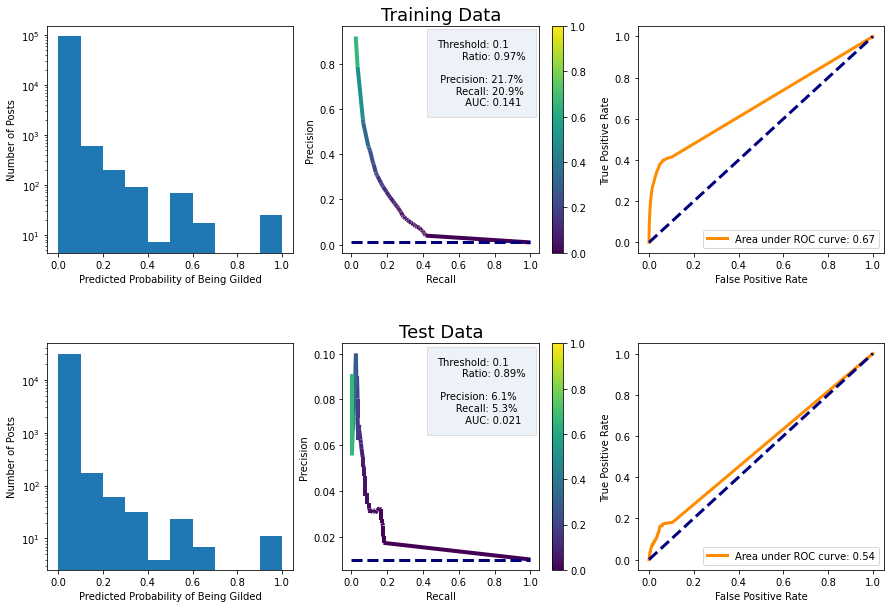

In [6]:
priors_clf = MyProbBuilder(['subreddit', 'post_hour'], ['upvote_rate'])
priors_clf.fit(X_train, y_train)

thresh = 0.1
make_evaluation_plots(priors_clf, X_train, y_train, X_test, y_test, thresh = thresh)

Unsurprisingly, this model does not generalize well (unsurprising because it is literally memorizing the training data). This can give a decent baseline for comparison, however. I will also experiment with using the historical gilding fraction as a feature for more complex models.

## XGBoost Classifier

Build a full suite of features from the data and train an XGBoost model on them.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: 

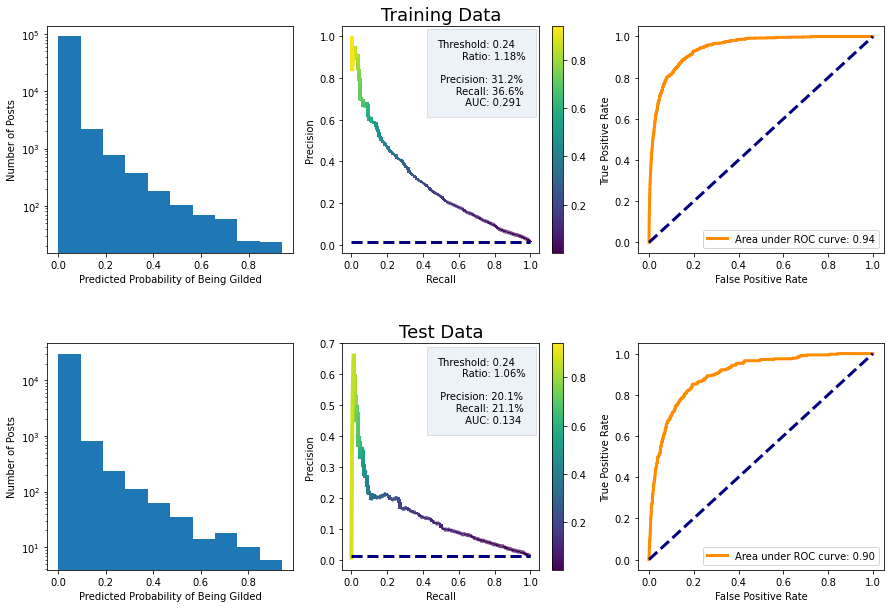

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.112434,0.121849,0.139125,0.15492,0.146395,0.134945,0.015658,1


In [7]:
current_ratio = y_train.sum()/(~y_train).sum()

xgb = XGBClassifier(eval_metric = 'aucpr', use_label_encoder = False, verbosity = 0 )

#rmf = RandomForestClassifier(n_jobs = -1)
over = SMOTE()
under = RandomUnderSampler()


resample_pipe = imb_Pipeline([('over', over),
                              ('under', under),
                              ('model', xgb)
                             ])

pipe = skl_Pipeline([('new_feats', AddNewFeatures(['Log_of_Features_Distance'])),
                     ('categ_enc', MultipurposeEncoder(ohe_feats = ohe_enc_feats, 
                                                       target_feats = target_enc_feats,
                                                       target_how = 'additive_smoothing',
                                                      )),
                     ('scaler', StandardScaler()),
                     #('decomp', PCA()),
                     ('resample_classify', resample_pipe)
                    ])


# https://xgboost.readthedocs.io/en/latest/parameter.html
parameters = {'resample_classify__model__eta':[0.25],
              'resample_classify__model__gamma':[2],
              'resample_classify__model__min_child_weight':[5],              
              'resample_classify__model__max_depth': [3],
              'resample_classify__model__max_delta_step': [10],
              'resample_classify__model__subsample': [1],
              'resample_classify__model__sampling_method': ['uniform'],
              'resample_classify__model__lambda': [10],
              'resample_classify__model__alpha': [0],
              'resample_classify__model__scale_pos_weight': [2],              
              'resample_classify__over__sampling_strategy': [current_ratio*1.01],
              'resample_classify__under__sampling_strategy': [current_ratio*1.01],              
              'categ_enc__target_weight': [0], 
             # 'decomp__n_components': [0.99],
              'new_feats__feat_names': [['Priors_Fractions', 'Log_of_Features_Distance']],
              'new_feats__weight': [3]
             }


clf = GridSearchCV(pipe,
                   parameters,
                   n_jobs = -1,
                   #scoring = pr_auc_scorer,
                   scoring = 'average_precision',
                   verbose = 1,
                  )
_ = clf.fit(X_train, y_train)

thresh = 0.24
make_evaluation_plots(clf, X_train, y_train, X_test, y_test, thresh = thresh)

cv_fits = pd.DataFrame(clf.cv_results_)
cv_fits.iloc[:,-8:].sort_values('rank_test_score', ascending = True)

In [8]:
# clf.best_params_

#### Feature importances:

In [10]:
cols = list(X_train.columns) + ['priors', 'log_feature']
cols.remove('post_age')
feat_imp = clf.best_estimator_['resample_classify']['model'].feature_importances_
pd.Series(feat_imp, index = cols).sort_values(ascending = False)

priors                0.158502
content_categories    0.113002
upvote_rate           0.104441
std_up_rate           0.065314
subreddit             0.063882
selfpost              0.062907
reddit_media          0.060587
log_feature           0.054148
distinguished_rate    0.033284
initial_silver        0.030717
comment_rate          0.029399
video                 0.027935
op_comment_rate       0.027687
premium_auth_rate     0.026907
upvote_ratio          0.025875
post_hour             0.025562
crossposts            0.024837
weekday               0.024195
avg_up_rate           0.022052
adult_content         0.018768
gild_rate             0.000000
distinguished         0.000000
oc                    0.000000
edited                0.000000
contest_mode          0.000000
dtype: float32

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


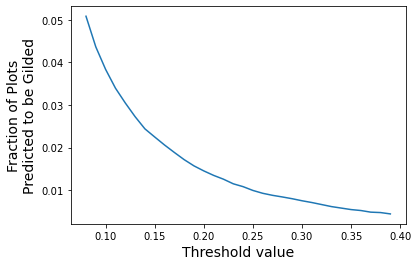

In [11]:
# Set thresh grid to check through
step = 0.01
upper = 0.4
lower = 0.08

probs = clf.predict_proba(X_test)
num_instances = len(probs)
thresh_vals = np.arange(lower, upper, step)
ratio = [sum([1 if prob > thresh else 0 for prob in probs[:,1]])/num_instances for thresh in thresh_vals]

fig, ax = plt.subplots(1,1)
ax.plot(thresh_vals, ratio)
ax.set_xlabel('Threshold value', fontsize = 14)
ax.set_ylabel('Fraction of Plots\nPredicted to be Gilded', fontsize = 14)
#ax.set_yscale('log')

plt.show()

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


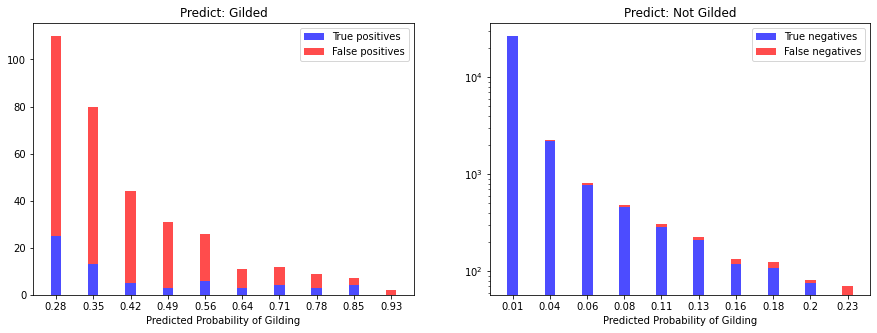

In [12]:
probas = [x[1] for x in clf.predict_proba(X_test)] 
predictions = [True if x > thresh else False for x in probas]

outcomes = pd.DataFrame({'gilded': y_test, 'predicted': predictions, 'probas': probas})
pos_outcomes = outcomes[ outcomes['predicted'] == True]
neg_outcomes = outcomes[ outcomes['predicted'] == False]

predicted_positive = (pos_outcomes
                      .groupby([pd.cut(pos_outcomes['probas'], bins=10)])
                      .sum()
                      .iloc[:,:-1]
                      .reset_index()
                     )
predicted_positive['center'] = predicted_positive['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_positive['false pos'] = predicted_positive['predicted'] - predicted_positive['gilded']

predicted_negative = (neg_outcomes
                      .groupby([pd.cut(neg_outcomes['probas'], bins=10)])
                      .agg(['count', 'sum'])
                      .iloc[:,:2]
                      .reset_index()
                     )
predicted_negative['center'] = predicted_negative['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_negative['true neg'] = predicted_negative[('gilded', 'count')] - predicted_negative[('gilded', 'sum')]
predicted_negative['false neg'] = predicted_negative[('gilded', 'sum')]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.bar(predicted_positive['center'],
       predicted_positive['gilded'],
       width=0.02,
       color = 'blue',
       alpha = 0.7,
       label = 'True positives'
      )
ax1.bar(predicted_positive['center'],
       predicted_positive['false pos'], 
       bottom = predicted_positive['gilded'],
       width=0.02,
       color = 'red',
       alpha = 0.7,
       label = 'False positives'
      )
ax1.set_xticks(predicted_positive['center'])
ax1.set_xticklabels([round(x,2) for x in predicted_positive['center']])
ax1.legend(loc = 'upper right')
ax1.set_title('Predict: Gilded')
ax1.set_xlabel('Predicted Probability of Gilding')

ax2.bar(predicted_negative['center'],
       predicted_negative['true neg'],
       width=0.007,
       color = 'blue',
       alpha = 0.7,
       label = 'True negatives'
      )
ax2.bar(predicted_negative['center'],
       predicted_negative['false neg'], 
       bottom = predicted_negative['true neg'],
       width=0.007,
       color = 'red',
       alpha = 0.7,
       label = 'False negatives'
      )
ax2.set_xticks(predicted_negative['center'])
ax2.set_xticklabels([round(x,2) for x in predicted_negative['center']])
ax2.legend(loc = 'upper right')
ax2.set_yscale('log')
ax2.set_title('Predict: Not Gilded')
ax2.set_xlabel('Predicted Probability of Gilding')


plt.show()